# Adaboost
For this exercise you will implement AdaBoost from scratch and applied it to a spam dataset. You will be classifying data into spam and not spam. You can call DecisionTreeClassifier from sklearn to learn your base classifiers.

Here is how you train a decision tree classifier with weights.

`
h = DecisionTreeClassifier(max_depth=1, random_state=0)
h.fit(X, Y, sample_weight=w)
`

## 2.1 Implement adaboost

In [128]:
%matplotlib inline

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [2]:
# accuracy computation
def accuracy(y, pred):
    return np.sum(y == pred) / float(len(y)) 

In [62]:
def parse_spambase_data(filename):
    """ Given a filename return X and Y numpy arrays

    X is of size number of rows x num_features
    Y is an array of size the number of rows
    Y is the last element of each row. (Convert 0 to -1)
    """
    # YOUR CODE HERE
    f = open(filename,'r')
    data = []
    for line in f.readlines():
        data.append(line.split(','))
    X = np.array(data)[:,:-1].astype(np.float16)
    Y = np.array(data)[:,-1]
    Y = np.array([int(i.replace('\n','')) for i in Y])
    Y[Y==0] = -1
#     raise NotImplementedError()
    return X, Y

In [63]:
y_test = np.array([1., -1., 1., 1., -1., -1., 1., 1., 1., -1.])
X, Y = parse_spambase_data("tiny.spam.train")
for i in range(len(y_test)): assert(y_test[i] == Y[i])
n, m = X.shape
assert(n == 10)
assert(m == 57)

In [64]:
def adaboost(X, y, num_iter):
    """Given an numpy matrix X, a array y and num_iter return trees and weights 
   
    Input: X, y, num_iter
    Outputs: array of trees from DecisionTreeClassifier
             trees_weights array of floats
    Assumes y is {-1, 1}
    """
    trees = []
    trees_weights = [] 
    N, _ = X.shape
    d = np.ones(N) / N

    # YOUR CODE HERE
    for i in range(num_iter):
        h = DecisionTreeClassifier(max_depth=1, random_state=0)
        h.fit(X,y,sample_weight=d)
        trees.append(h)
        pred = h.predict(X)
        err = np.sum((y!=pred)*d)/np.sum(d)
        if err == 0:
            err+=.000001
        trees_weights.append(np.log((1-err)/err))
        d[y!=pred] = d[y!=pred]*((1-err)/err)
#     raise NotImplementedError()
    return trees, trees_weights

In [65]:
X, Y = parse_spambase_data("tiny.spam.train")
trees, weights = adaboost(X, Y, 2)
assert(len(trees) == 2)
assert(len(weights) == 2)
assert(isinstance(trees[0], DecisionTreeClassifier))

In [66]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
h = trees[0]
pred = h.predict(x)
for i in range(len(y)): assert(pred[i] == y[i])

In [67]:
def adaboost_predict(X, trees, trees_weights):
    """Given X, trees and weights predict Y
    """
    # X input, y output
    N, _ =  X.shape
    y = np.zeros(N)
    # YOUR CODE HERE
    for i,t in enumerate(trees):
         y = y + t.predict(X)*trees_weights[i]
    y = np.sign(y)
#     raise NotImplementedError()
    return y

In [68]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
pred = adaboost_predict(x, trees, weights)
for i in range(len(y)):
    assert(pred[i] == y[i])

In [69]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10)
Yhat = adaboost_predict(X, trees, trees_weights)
Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
acc_test = accuracy(Y_test, Yhat_test)
acc_train = accuracy(Y, Yhat)
print("Train Accuracy %.4f" % acc_train)
print("Test Accuracy %.4f" % acc_test)
assert(np.around(acc_train, decimals=4)==0.9111)
assert(np.around(acc_test, decimals=4)==0.9190)

Train Accuracy 0.9111
Test Accuracy 0.9190


## 2.2 Tuning for numTrees

In [70]:
num_trees = [100,200,300,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [71]:
err_train = []
err_test = []
for n in num_trees:
    trees, trees_weights = adaboost(X, Y, n)
    Yhat = adaboost_predict(X, trees, trees_weights)
    Yhat_test = adaboost_predict(X_test, trees, trees_weights)

    err_test.append(1-accuracy(Y_test, Yhat_test))
    err_train.append(1-accuracy(Y, Yhat))    

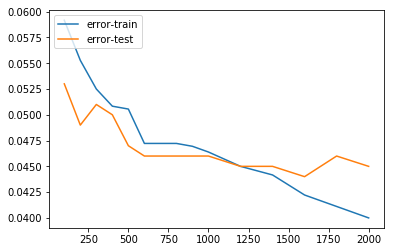

In [72]:
import matplotlib.pyplot as plt
plt.plot(num_trees,err_train)
plt.plot(num_trees,err_test)
plt.legend(['error-train', 'error-test'], loc='upper left')
plt.show()

**We can see that validation (test) error is minimum for 1600 trees and after that the error starts to go up. From this experiment we can conclude that the best value of number of trees will be 1600.**

In [14]:
print(f'Train accuracy for the best value of num_trees:{100*(1-err_train[12])}')
print(f'Test accuracy for the best value of num_trees:{100*(1-err_test[12])}')

Train accuracy for the best value of num_trees:95.77777777777777
Test accuracy for the best value of num_trees:95.6


## 2.3 XGBoost

In [190]:
import xgboost as xgb
import pandas as pd
import numpy as np

Data needs to be stored in `DMatrix` object which is designed to handle sparse datasets.

In [218]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")

In [219]:
Y[Y==-1] = 0
Y_test[Y_test==-1] = 0

In [220]:
dtrain = xgb.DMatrix(X,Y)
dtest = xgb.DMatrix(X_test,Y_test)

In [221]:
print("Train dataset contains {0} rows and {1} columns".format(dtrain.num_row(), dtrain.num_col()))
print("Test dataset contains {0} rows and {1} columns".format(dtest.num_row(), dtest.num_col()))

Train dataset contains 3600 rows and 57 columns
Test dataset contains 1000 rows and 57 columns


In [222]:
print("Train possible labels: ")
print(np.unique(dtrain.get_label()))

print("\nTest possible labels: ")
print(np.unique(dtest.get_label()))

Train possible labels: 
[ 0.  1.]

Test possible labels: 
[ 0.  1.]


### Specify training parameters<a name='params' />
Let's make the following assuptions and adjust algorithm parameters to it:
- we are dealing with binary classification problem (`'objective':'binary:logistic'`),
- we want shallow single trees with no more than 2 levels (`'max_depth':2`),
- we don't any oupout (`'silent':1`),
- we want algorithm to learn fast and aggressively (`'eta':1`),
- we want to iterate only 5 rounds

In [223]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':1
}
num_rounds = 1000

### Training using Learning API

We can also observe performance on test dataset using `watchlist`

In [226]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist,early_stopping_rounds=10,verbose_eval=False)

In [230]:
bst.best_iteration

83

In [233]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_boost_round=83, evals=watchlist,verbose_eval=False)

In [235]:
# #print dettails for each treee
# bst.dump_model(fout='featmap.txt',with_stats=True)
# trees_dump = bst.get_dump(fmap='featmap.txt', with_stats=True)
# for tree in trees_dump:
#     print(tree)

### Predictions

In [237]:
preds_prob = bst.predict(dtest)
preds_prob.shape

(1000,)

In [238]:
labels = dtest.get_label()
preds = preds_prob > 0.5 # threshold
correct = 0

for i in range(len(preds)):
    if (labels[i] == preds[i]):
        correct += 1

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-correct/len(preds)))

Predicted correctly: 964/1000
Error: 0.0360


### feature importance

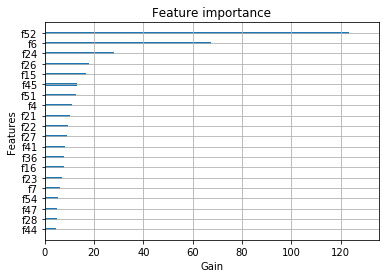

In [239]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain',max_num_features=20,show_values=False) #based on gain

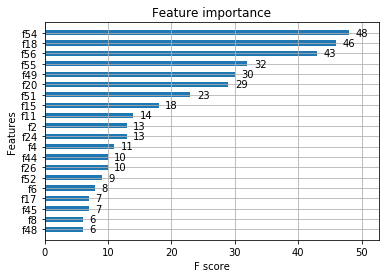

In [240]:
xgb.plot_importance(bst,max_num_features=20,height=.5) #based on F-score

### Training using Scikit API

In [241]:
print("Train dataset contains {0} rows and {1} columns".format(X.shape[0], X.shape[1]))
print("Test dataset contains {0} rows and {1} columns".format(X_test.shape[0], X_test.shape[1]))

Train dataset contains 3600 rows and 57 columns
Test dataset contains 1000 rows and 57 columns


In [242]:
print("Train possible labels: ")
print(np.unique(Y))

print("\nTest possible labels: ")
print(np.unique(Y_test))

Train possible labels: 
[0 1]

Test possible labels: 
[0 1]


In [244]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':1,
    'num_rounds':83
}

In [245]:
bst = xgb.XGBClassifier(**params).fit(X, Y)

In [246]:
preds = bst.predict(X_test)
preds[:5]

array([0, 1, 0, 0, 1])

In [247]:
from sklearn.metrics import accuracy_score
correct = 0

for i in range(len(preds)):
    if (Y_test[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(Y_test, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))

Predicted correctly: 955/1000
Error: 0.0450


### Tuning number of trees

In [248]:

import matplotlib.pyplot as plt
from sklearn.learning_curve import validation_curve
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

seed = 123
np.random.seed(seed)

In [253]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.3,
    'silent': 1.0
}

n_estimators_range = np.linspace(1, 300, 10).astype('int')

train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(**default_params),
    X, Y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=3,
    scoring='accuracy'
)

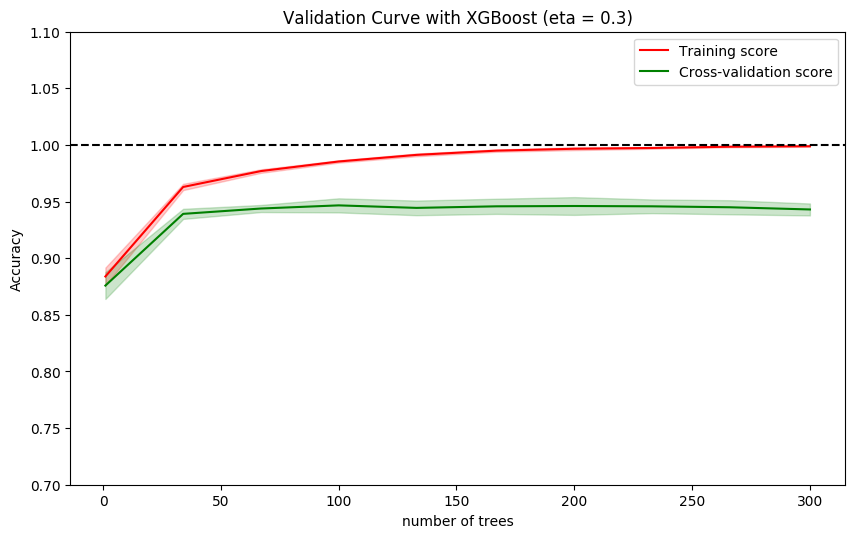

Best cross-validation result (0.95) obtained for 100 trees


In [254]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

Looking at the plot we can draw the following conclusions:

- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- from about 100 trees, the variance is getting higher and while the CV score bias is holding steady (there is no point for adding extra trees / complexity)
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity

We can assume that the trade-off for our model will be met at `n_estimators = 100`.

### What we can do?<a name='deal' />

#### Dealing with high variance
If model is too complex try:
- using less features (ie. feature selection),
- using more training samples (ie. artificially generated),
- increasing regularization (add penalties for extra complexity)

In XGBoost you can try to:
- reduce depth of each tree (`max_depth`),
- increase `min_child_weight` parameter,
- increase `gamma` parameter,
- add more randomness using `subsample`, `colsample_bytree` parameters,
- increase `lambda` and `alpha` regularization parameters

#### Dealing with high bias
If model is too simple:
- add more features (ie. better feature engineering),
- more sophisticated model
- decrease regularization

In XGBoost you can do it by:
- increase depth of each tree (`max_depth`),
- decrease `min_child_weight` parameter,
- decrease `gamma` parameter,
- decrease `lambda` and `alpha` regularization parameters

Let's try to tweak a parameters a little bit. We are going to add some randomness - each tree we will use 70% randomly chosen samples and 60% randomly chosen features. This should help to reduce a variance.

### Hyperparameter tuning

In [255]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

In [256]:
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1,
    'n_estimators':100
}

In [257]:
params_dist_grid = {
    'max_depth': [1, 2, 3, 4],
    'gamma': [0, 0.5, 1],
    'learning_rate': uniform(), # gaussian distribution
    'subsample': uniform(), # gaussian distribution
    'colsample_bytree': uniform() # gaussian distribution
}

In [258]:
rs_grid = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(**params_fixed, seed=100),
    param_distributions=params_dist_grid,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=100
)

In [259]:
rs_grid.fit(X, Y)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100, silent=1,
       subsample=1),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'max_depth': [1, 2, 3, 4], 'gamma': [0, 0.5, 1], 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1125980f0>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1125983c8>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x111875978>},
          pre_dispatch='2*n_jobs', random_state=100, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [260]:
rs_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.73299501983799231, gamma=0,
       learning_rate=0.25155065329556847, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100, silent=1,
       subsample=0.40588132236756125)

In [261]:
rs_grid.best_params_

{'colsample_bytree': 0.73299501983799231,
 'gamma': 0,
 'learning_rate': 0.25155065329556847,
 'max_depth': 2,
 'subsample': 0.40588132236756125}

In [262]:
rs_grid.best_score_

0.94694444444444448

### Using the parameters from grid search

In [263]:
params = {
    'objective':'binary:logistic',
    'silent':1,
    'n_estimators': 100,
'colsample_bytree': 0.73299501983799231,
 'gamma': 0,
 'learning_rate': 0.25155065329556847,
 'max_depth': 2,
 'subsample': 0.40588132236756125}

In [264]:
bst = xgb.XGBClassifier(**params).fit(X, Y)

In [265]:
preds = bst.predict(X_test)
preds[:5]

array([0, 1, 0, 0, 1])

In [266]:
from sklearn.metrics import accuracy_score
correct = 0

for i in range(len(preds)):
    if (Y_test[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(Y_test, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))

Predicted correctly: 956/1000
Error: 0.0440


**So we're getting a better result using learning API and early stopping rounds**

### Final model

In [312]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':1
}

In [313]:
bst = xgb.train(params, dtrain, num_boost_round=83,verbose_eval=False)

### Predictions

In [314]:
preds_prob = bst.predict(dtest)
preds_prob.shape

(1000,)

In [315]:
labels = dtest.get_label()
preds = preds_prob > 0.5 # threshold
correct = 0

for i in range(len(preds)):
    if (labels[i] == preds[i]):
        correct += 1

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-correct/len(preds)))

Predicted correctly: 964/1000
Error: 0.0360


### Conclusion
* We can see that xgboost takes very less number of trees compared to adaboost to get a better solution. Adaboost required 1600 trees whereas xgboost required only 83 trees
* Accuracy of on test: Adaboost: 95.6%   XGboost: 96.4%